In [ ]:
!pip install adjustText
!pip install catboost
!pip install shap
!pip install eli5
import pandas as pd
import re
import warnings
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import shap
import eli5
from eli5.sklearn import PermutationImportance  
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
from textwrap import wrap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import  classification_report, log_loss, roc_auc_score
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
games = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games.csv")
details = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games_details.csv")
teams = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/teams.csv")
players = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/players.csv")
ranking = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/ranking.csv")

In [ ]:
# Reformatage Player NAME
details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')   #     .* <=> followed by 0 or more (any) characters       ^<=> starts with 
# Reformatage Colonne  MIN
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

In [ ]:
# DONNEES DE BASE DE LA TABLE 'INITIALE' GAME
games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def get_season(date): ###
    '''
    Returns the season based on the month and year of a date
    '''
    date = pd.to_datetime(date, format='%Y-%m-%d')
    if (date.month >= 10):
        season = date.year
    else:
        season = date.year - 1
    return season

def get_season_data(season):
    ''' 
    Aggregates the details data into yearly figures
    Returns the aggregated data and the standardised aggregated data    
    '''
    # Création nouvelles tables à partir de la table details
    temp = details.loc[details.GAME_ID.isin(games.loc[games.SEASON == season, 'GAME_ID'])]
    temp = temp.loc[~temp['PLAY_TIME'].isnull()]
    agg_df = temp.groupby(['PLAYER_ID', 'PLAYER_NAME', 'PLAYER_NAME_SHORT'])[['FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLAY_TIME']].sum().reset_index()
    agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1200].reset_index(drop = True) #### choix arbitraire de 1200min
    st_agg_df = StandardScaler().fit_transform(agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']))
    return(agg_df, st_agg_df)

In [ ]:
# MACHINE LEARNING NON SUPERVISE -> PCA
pca = PCA(n_components = 3)
agg_df, st_agg_df = get_season_data(2020) ###
pcomp = pca.fit_transform(st_agg_df) # PCA sur données standardisées
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2','PC 3'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')

,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.39,0.39,0.19,0.18,0.36,0.37,0.05,0.23,0.31,0.20,0.02,0.38,0.15
PC 2,-0.10,0.01,-0.41,-0.41,0.11,0.05,0.50,0.35,-0.09,-0.04,0.42,0.03,0.28
PC 3,-0.14,-0.12,-0.42,-0.45,0.14,0.13,-0.12,-0.22,0.43,0.29,-0.29,0.20,-0.30


In [ ]:
pca = PCA(n_components = 2)
agg_df, st_agg_df = get_season_data(2020)
pcomp = pca.fit_transform(st_agg_df)
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')

,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.39,0.39,0.19,0.18,0.36,0.37,0.05,0.23,0.31,0.20,0.02,0.38,0.15
PC 2,-0.10,0.01,-0.41,-0.41,0.11,0.05,0.50,0.35,-0.09,-0.04,0.42,0.03,0.28


In [ ]:
def pca_plots(season, ax = None):
    '''
    Performs PCA on season data
    Calculates the top players based on the 2 PCs
    Creates a scatter plot for visualising the season data
    '''    
    #pca = PCA(n_components = 3)
    pca = PCA(n_components = 2)
    agg_df, st_agg_df = get_season_data(season)
    pcomp = pca.fit_transform(st_agg_df)    
    overall = pcomp.sum(axis = 1)
    top_overall = np.argpartition(overall, -4)[-4:]
    top_pc1 = np.argpartition(pcomp[:,0], -4)[-4:]
    top_pc2 = np.argpartition(pcomp[:,1], -4)[-4:]
    # top_pc3 = np.argpartition(pcomp[:,2], -4)[-4:]
    # top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_pc3) + list(top_overall)))
    top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_overall)))
    ##alphas = np.zeros(pcomp.shape[0]) + 0.3
    ##alphas[top_pc] = 1    
    # ax.scatter(pcomp[:, 0], pcomp[:, 1], pcomp[:, 2], alpha = alphas)
    ax.scatter(pcomp[:, 0], pcomp[:, 1])##, alpha = alphas)
    ax.axhline(y = 0, color ='green', linestyle='--', lw=1)
    ax.axvline(x = 0, color ='green', linestyle='--', lw=1)
    #texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1], z=pcomp[i, 2],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    adjust_text(texts, ax = ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    _ = ax.set_title(str(season))

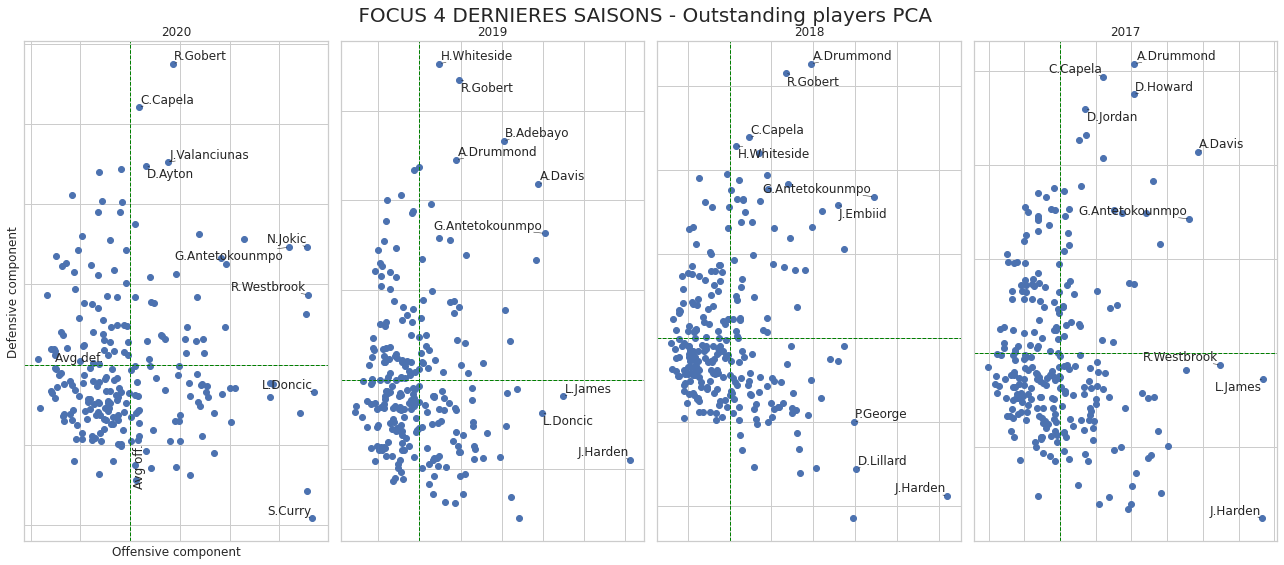

In [ ]:
# FOCUS SUR LES 4 DERNIERES SAISONS
fig,axes = plt.subplots(1, 4, figsize=(18,8))
for i,season in enumerate(range(games.SEASON.max(), games.SEASON.min()+13, -1)):
    pca_plots(season, ax = axes.ravel()[i])    
    axes.ravel()[i].tick_params(bottom=False, left=False, labelbottom = False, labelleft = False)
    if (i % 5 == 0 ):
        axes.ravel()[i].set_xlabel('Offensive component')
        axes.ravel()[i].set_ylabel('Defensive component')
        axes.ravel()[i].text(x = 0.1, y = -3, s = 'Avg off.',rotation=90)
        axes.ravel()[i].text(x = -3, y = 0.1, s = 'Avg def.')
fig.suptitle(' FOCUS 4 DERNIERES SAISONS - Outstanding players PCA', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

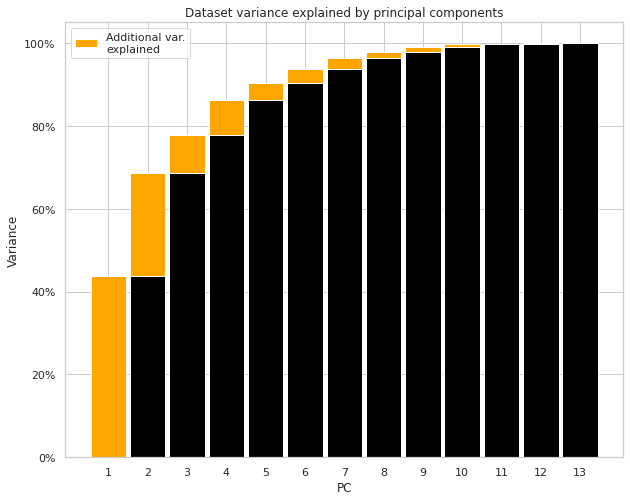

In [ ]:
# explication de la variance vs nb de composantes principales
pca_all = PCA()
pca_all.fit(st_agg_df)
cum_var = np.cumsum(pca_all.explained_variance_ratio_)
cum_var = np.insert(cum_var, 0, 0)
cum_var = cum_var[:-1]

comp = [str(x + 1) for x in range(pca_all.n_components_)]
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(comp, cum_var, align='center', width=0.9, color='black', label='_nolegend_')
ax.bar(comp, pca_all.explained_variance_ratio_, bottom=cum_var, align='center', width=0.9, color='orange', label= '\n'.join(wrap('Additional var. explained', 20)))
ax.set_ylabel('Variance')
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_xlabel('PC')
ax.set_title('Dataset variance explained by principal components')
ax.legend()
plt.show()

## **Preparation of modelling**

In [ ]:
# PREPARATION DES TABLES

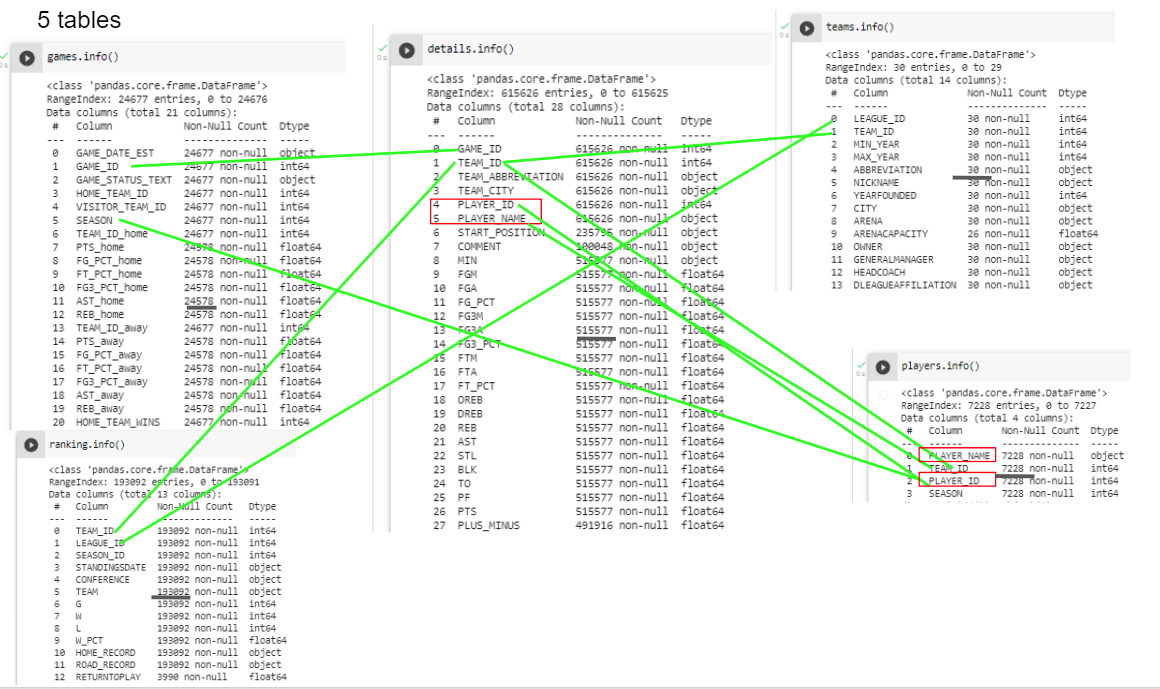

In [ ]:
# TABLE RANKING
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)
ranking.head(1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,MAX_S_GAMES
164300,1610612752,0,2002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN,82


In [ ]:
## A PARTIR DE LA TABLE RANKING
# Création d'un df avec début et fin de saison pour exclure les matchs de pré-saison et éliminatoires
start_dates = ranking.loc[ranking.SEASON_ID > 2015].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()     #ranking.SEASON_ID > 2002     ######
t = ranking.loc[(ranking['G'] == ranking['MAX_S_GAMES'])].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()


In [ ]:
# playoff_dates = t.loc[(t.TEAMS == 30) | ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
playoff_dates = t.loc[(t.TEAMS == 30)].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()                                                  ######
dates = start_dates.merge(playoff_dates, how = 'left')
#dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season
dates.head(1)

,SEASON_ID,FIRST_GAME,LAST_GAME
0,2016,2016-10-25,2017-04-12


In [ ]:
# TABLE DETAILS - selection des données de la saison régulière
# FUSION 1 
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
# FUSION 2
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]
#details = details.loc[(details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME)]
details.head(1)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,PLAYER_NAME_SHORT,MINS,SECS,PLAY_TIME,GAME_DATE_EST,SEASON,SEASON_ID,FIRST_GAME,LAST_GAME
645,22001073,1610612738,BOS,Boston,1628400,Semi Ojeleye,F,NaN,16:18,2.0,6.0,0.333,1.0,5.0,0.2,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,5.0,-10.0,S.Ojeleye,16.0,18.0,16.0,2021-05-16,2020,2020.0,2020-12-22,2021-05-16


In [ ]:
# TABLE GAMES (DONNEES DE BASE DE LA TABLE INITIALE)
# FUSION 1
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
# selection des données de la saison régulière 
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)
games.head(1)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
22,2021-05-16,22001073,Final,1610612752,1610612738,2020,1610612752,96.0,0.43,0.789,0.481,16.0,41.0,1610612738,92.0,0.407,0.733,0.268,19.0,46.0,1


In [ ]:
## A PARTIR DE LA TABLE RANKING -> Création d'un nouveau df RANKING_SHORT avec la saison régulière uniquement et des valeurs pouvant être utilisées pour la modélisation
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]

In [ ]:
### encodage manuel ONE HOT
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric) 
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)
ranking_short.tail(1)

,TEAM_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L
47692,1610612755,2021-05-16,East,Philadelphia,72,49,23,29,7,20,16


In [ ]:
## A PARTIR DE LA TABLE GAMES -> Création d'un nouveau df GAMES_SHORT avec la saison régulière uniquement et des valeurs pouvant être utilisées pour la modélisation
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

## Calculating ELO for each team
La statistique ELO a été initialement conçue pour classer les joueurs dans les parties d'échecs. Les points principaux du calcul :

Gagner une partie augmente l'ELO de l'équipe et perdre une partie le diminue
Le montant de l'augmentation/diminution dépend a) de la marge de victoire b) des attentes d'avant-match pour le résultat du match (qui sont basées sur la cote ELO des deux équipes)
**Les notes sont ajustées après chaque match**


In [ ]:
# https://www.chiefdelphi.com/t/2016-pre-champs-elo-ratings/151752
#https://www.chiefdelphi.com/t/paper-weeks-1-2-elo-analysis/135776

In [ ]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change
        


In [ ]:
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()

# INITIALISATION DE NOUVELLES COLONNES DANS LA TABLE elo_data
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)
elo_data.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,PTS_away,MOV,HOME_ELO,VISITOR_ELO,ELO_DIFF,HOME_WIN_PR,VISITOR_WIN_PR
0,2016-10-26,21600013,1610612747,1610612745,2016,120.0,114.0,6.0,0,0,0,0,0
1,2016-10-26,21600004,1610612753,1610612748,2016,96.0,108.0,-12.0,0,0,0,0,0
2,2016-10-26,21600005,1610612754,1610612742,2016,130.0,121.0,9.0,0,0,0,0,0
3,2016-10-26,21600006,1610612738,1610612751,2016,122.0,117.0,5.0,0,0,0,0,0
4,2016-10-26,21600007,1610612761,1610612765,2016,109.0,91.0,18.0,0,0,0,0,0


In [ ]:
teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')),'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []
## Pour obtenir l'indice de la colonne à partir de son nom, une solution est d'utiliser get_loc (),
current_season = 2020
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

In [ ]:
for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(10).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100

    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values

    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]

    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])

    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    
    update_elo(team_elo, elo_data.iloc[i])

team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season)) #current_season

In [ ]:
team_elo_l

[          TEAM   ELO NAME  SEASON
 0   1610612747  1500  LAL    2020
 1   1610612753  1500  ORL    2020
 28  1610612764  1500  WAS    2020
 27  1610612750  1500  MIN    2020
 26  1610612745  1500  HOU    2020
 25  1610612746  1500  LAC    2020
 24  1610612759  1500  SAS    2020
 23  1610612743  1500  DEN    2020
 22  1610612739  1500  CLE    2020
 21  1610612752  1500  NYK    2020,           TEAM          ELO NAME  SEASON
 29  1610612744  1748.284870  GSW    2016
 24  1610612759  1635.135412  SAS    2016
 25  1610612746  1623.468837  LAC    2016
 14  1610612762  1608.660999  UTA    2016
 26  1610612745  1594.809426  HOU    2016
 4   1610612761  1590.621147  TOR    2016
 28  1610612764  1580.508974  WAS    2016
 3   1610612738  1578.551347  BOS    2016
 16  1610612748  1561.050440  MIA    2016
 11  1610612757  1550.886853  POR    2016,           TEAM          ELO NAME  SEASON
 26  1610612745  1726.287580  HOU    2017
 14  1610612762  1681.248508  UTA    2017
 4   1610612761  1674.95799

In [ ]:
sorted_team_elo = team_elo.sort_values(ascending=False,by='ELO')

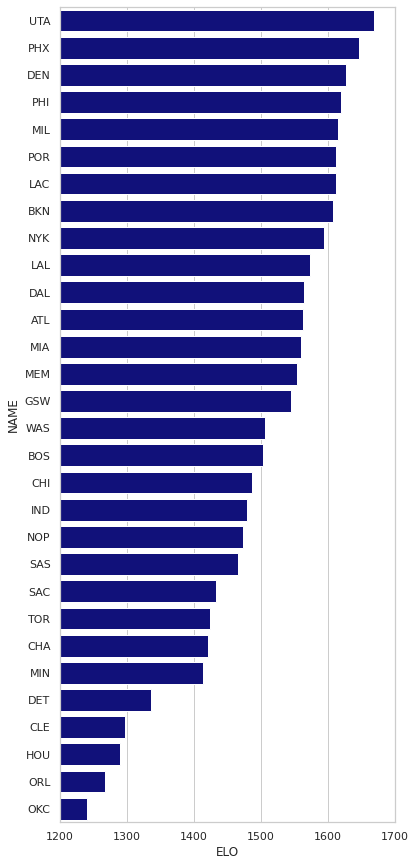

In [ ]:
sn.set_theme(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="ELO", y="NAME", data=sorted_team_elo,
            label="ELO", color="darkblue")
ax.set(xlim=(1200, 1700));

##  **Incorporating player efficiency**
Basketball is a sport where key players can have substantial impact on the team's success. Therefore, it is crucial to incorporate this information in the modelling dataset.
This sounds straightforward in theory but in practice there is an important issue to be adressed: There is no all-encompassing metric for efficiency in basketball. The most popular one is the Player efficiency rating (PER) developed by John Hollinger.
Given that not all figures that are required in the calculation are available in the dataset, a different efficiency measure was used: (taken from Breakthroughbasketball)
## Efficiency = Pts + Rebs + Ast + Stl + Blk – (TO + FG Misses + FT Misses)
One benefit that I found in this statistic is that it does filter for games played as the number of all of these figures increases with more games. This means that there is no need for an arbitrary cut-off for season games. Using this efficiency measure the following features were added to the dataset:
1) Players in a team that had a top 30 efficiency rating last season.
2) A measure of "team" efficiency by summing the last season efficiency of all players per team per game

The player efficiency figures for the 2019 season can be seen below:

In [ ]:
# https://en.wikipedia.org/wiki/Player_efficiency_rating

In [ ]:
details['FGMISSES'] = details.FGA - details.FGM
details['FTMISSES'] = details.FTA - details.FTM
details['EFF'] = details.PTS + details.REB + details.AST + details.STL + details.BLK - (details.TO + details.FGMISSES + details.FTMISSES)

# Creating the efficiency dataset
eff = details[['PLAYER_NAME', 'PLAYER_ID', 'SEASON', 'EFF']].copy()
eff.dropna(inplace=True)
eff = eff.groupby(['PLAYER_NAME', 'PLAYER_ID', 'SEASON'], as_index=False).sum()
eff.sort_values('EFF', ascending=False, inplace=True)
top_players = eff.groupby('SEASON', as_index=False).head(300).copy()  ####
top_players['NEXT_SEASON'] = top_players.SEASON + 1
eff['NEXT_SEASON'] = eff.SEASON + 1

# Efficiency per game per team
per_game_eff = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(eff, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
pge = per_game_eff.groupby(['GAME_ID', 'TEAM_ID'], as_index=False).EFF.mean()
pge.dropna(inplace= True)

# Top players based on efficiecy for the 2019 season
top_players.loc[top_players.SEASON == 2019, ['PLAYER_NAME', 'EFF']].T

,3970,5775,7035,3318,535,732,5926,1879,7993,4523,5148,4310,3506,2487,7056,2608,1568,2640,8011,2250,4765,5426,8963,8842,3911,352,7215,8245,4618,5596,4130,1204,4300,943,771,991,5524,6827,8600,5222,5014,7761,8549,9539,3740,4982,3173,8215,124,1972,7744,1170,7310,3676,1984,3814,2732,5884,3365,1132,2356,5357,6926,6191,5647,6027,8427,6201,7100,2984,3381,6871,5132,2767,24,2533,5841,4658,3087,4386,4572,8701,2203,2317,9141,3485,7193,8807,6786,1681,1616,6271,1652,975,6476,9418,183,2680,9075,5208,4565,2221,4800,889,2304,5231,3771,473,6639,5202,2450,7080,4115,7955,8687,6821,7327,2037,1316,1783,2427,6587,2649,882,9082,6367,8751,8851,2570,3662,6299,4902,2031,5724,3848,7985,6751,2973,1668,2323,5287,7712,5581,8593,2444,3016,1255,3261,2195,7195,8231,6958,3350,5051,3719,2010,3758,4954,6662,5740,2432,8644,7995,1141,869,1798,1658,934,8729,4363,5553,9376,5337,7242,2205,8243,3389,6281,6110,7492,3210,8663,37,1902,766,1353,4290,7448,2694,5279,2917,2709,9443,3227,7225,3064,209,7279,9223,6792,4776,4346,1487,1731,197,4935,7900,9062,4407,707,5703,3781,3181,2208,3957,1162,1239,5503,8620,9033,6359,9403,8895,9590,819,6834,2040,3853,6526,8945,669,3247,3615,2774,8931,492,1235,3002,5625,6464,2042,6728,4132,6061,6054,850,7020,6551,1870,3149,5696,3402,8248,6239,6374,5578,7127,5417,3488,3269,5384,5951,7654,8577,8400,3157,7804,2803,7790,2964,5834,4502,5055,4838,3575,8767,2545,718,2231,5342,4843,9382,8832,5086,8499,1150,7266,5546,8378,3824,3649,6142,3475,4997,7811,4670,1949,5270,1660,9049
PLAYER_NAME,James Harden,LeBron James,Nikola Jokic,Giannis Antetokounmpo,Anthony Davis,Bam Adebayo,Luka Doncic,Damian Lillard,Rudy Gobert,Jimmy Butler,Kawhi Leonard,Jayson Tatum,Hassan Whiteside,Devin Booker,Nikola Vucevic,Domantas Sabonis,Chris Paul,Donovan Mitchell,Russell Westbrook,DeMar DeRozan,Jonas Valanciunas,Khris Middleton,Trae Young,Tobias Harris,Jamal Murray,Andre Drummond,Pascal Siakam,Shai Gilgeous-Alexander,Joel Embiid,Kyle Lowry,Jarrett Allen,CJ McCollum,Jaylen Brown,Bradley Beal,Ben Simmons,Brandon Ingram,Kristaps Porzingis,Montrezl Harrell,T.J. Warren,Kemba Walker,Julius Randle,Robert Covington,Steven Adams,Zach LaVine,Ja Morant,Jrue Holiday,Fred VanVleet,Serge Ibaka,Al Horford,Daniel Theis,Ricky Rubio,Buddy Hield,Paul George,Ivica Zubac,Danilo Gallinari,Jae Crowder,Duncan Robinson,Lou Williams,Goran Dragic,Brook Lopez,Dennis Schroder,Kevin Love,Nemanja Bjelica,Marcus Morris Sr.,LaMarcus Aldridge,Malcolm Brogdon,Spencer Dinwiddie,Marcus Smart,OG Anunoby,Eric Bledsoe,Gordon Hayward,Myles Turner,Karl-Anthony Towns,Dwight Howard,Aaron Gordon,Devonte' Graham,Lonzo Ball,John Collins,Evan Fournier,Jerami Grant,Joe Ingles,Terry Rozier,De'Aaron Fox,Dejounte Murray,Tyler Herro,Harrison Barnes,P.J. Tucker,Tim Hardaway Jr.,Mitchell Robinson,Collin Sexton,Christian Wood,Markelle Fultz,Clint Capela,Brandon Clarke,Maxi Kleber,Will Barton,Alec Burks,Dorian Finney-Smith,Tristan Thompson,Kelly Oubre Jr.,Joe Harris,DeAndre Jordan,Jordan Clarkson,Bojan Bogdanovic,Deandre Ayton,Kendrick Nunn,JaVale McGee,Andrew Wiggins,Mikal Bridges,Kelly Olynyk,Derrick White,Norman Powell,Jaren Jackson Jr.,Royce O'Neale,Terrence Ross,Monte Morris,Paul Millsap,Dario Saric,Carmelo Anthony,D'Angelo Russell,Derrick Favors,Michael Porter Jr.,Donte DiVincenzo,Bogdan Bogdanovic,Troy Brown Jr.,Mason Plumlee,Thomas Bryant,Tomas Satoransky,Dillon Brooks,Ish Smith,Marquese Chriss,Josh Hart,Danuel House Jr.,Larry Nance Jr.,Jakob Poeltl,Rudy Gay,Miles Bridges,Enes Kanter,Cody Zeller,Delon Wright,Kentavious Caldwell-Pope,Richaun Holmes,Kyle Kuzma,T.J. McConnell,Derrick Rose,Eric Paschall,Caris LeVert,George Hill,Davis Bertans,P.J. Washington,Seth Curry,Nerlens Noel,Glenn Robinson III,Justin Holiday,JJ Redick,Danny Green,JaMychal Green,Josh Richardson,Mike Conley,Lauri Markkanen,Derrick Jones Jr.,Taurean Prince,Rui Hachimura,Bruce Brown,Bobby Portis,D.J. Augustin,Coby White,Brad Wanamaker,Thaddeus Young,Jeff Teague,Kyle Anderson,Wendell Carter Jr.,Kevin Huerter,Patrick Beverley,De'Andre Hunter,Shabazz Napier,Gorgui

In [ ]:
# Top players based on efficiecy for the De season
top_players.loc[top_players.SEASON == 2020, ['PLAYER_NAME', 'EFF']].T

,7036,3319,5015,7057,8012,5927,8467,1880,2609,7994,4311,9591,733,1569,4766,1653,8964,4619,944,2305,2488,5427,9540,2251,5149,5133,5626,4524,2974,3971,992,2318,8843,8702,2204,6588,4301,4659,7713,4131,7216,5776,772,5203,474,4983,5554,7311,6028,2710,7449,6640,3741,8730,2641,1682,537,1171,3849,6828,3486,8594,7081,6368,1488,3677,5321,3174,6752,1659,4387,7196,4573,4801,890,870,3816,5186,1205,1133,7762,4566,3912,8808,353,5597,3854,5525,5649,2357,7956,5842,2324,1617,6663,5582,7745,1256,9179,6903,3637,3382,2571,5338,2650,1973,2768,2733,8550,9377,2043,2985,2695,7791,8069,976,1142,5209,9142,8246,6959,536,2222,7014,4347,6872,5052,1317,7268,2534,2681,2011,7996,5232,5418,5223,7655,7805,2428,883,7986,2445,4903,7101,9419,6202,5271,7631,4920,6192,3815,8249,2041,25,1784,5741,7226,4125,4955,3636,9076,5087,2466,8232,1669,1985,7328,5288,3088,4718,3248,6344,1248,1732,2740,8852,3476,3366,6055,184,5885,8662,7582,9224,4291,8624,6849,7280,2918,820,8216,1678,3608,3619,9469,210,1240,2196,8734,9495,1950,8688,5402,5280,9268,836,1354,3759,4993,6822,3107,2775,3406,5908,5301,2209,3806,6477,1163,5952,5835,7353,8500,2433,5725,2451,6793,4844,8621,2302,198,8896,2261,5697,125,2713,374,3211,8578,6111,8664,6282,6787,9444,3270,3983,2348,1903,3772,1637,7000,9180,493,4031,1799,2038,670,3663,2366,7200,6375,3150,3182,3958,8946,2527,8401,4408,3507,4834,4998,2232,4364,6062,8645,935,3862,38,5358,4936,5385,7447,7493,9368,3629,8068,7387,3403,2890,6020,8450,3390,9112,2206,5648,6835,7018,7147,7194,187
PLAYER_NAME,Nikola Jokic,Giannis Antetokounmpo,Julius Randle,Nikola Vucevic,Russell Westbrook,Luka Doncic,Stephen Curry,Damian Lillard,Domantas Sabonis,Rudy Gobert,Jayson Tatum,Zion Williamson,Bam Adebayo,Chris Paul,Jonas Valanciunas,Clint Capela,Trae Young,Joel Embiid,Bradley Beal,Deandre Ayton,Devin Booker,Khris Middleton,Zach LaVine,DeMar DeRozan,Kawhi Leonard,Karl-Anthony Towns,Kyrie Irving,Jimmy Butler,Enes Kanter,James Harden,Brandon Ingram,Dejounte Murray,Tobias Harris,Terry Rozier,De'Aaron Fox,Michael Porter Jr.,Jaylen Brown,John Collins,Richaun Holmes,Jarrett Allen,Pascal Siakam,LeBron James,Ben Simmons,Kelly Olynyk,Andrew Wiggins,Jrue Holiday,Kyle Anderson,Paul George,Malcolm Brogdon,Draymond Green,RJ Barrett,Mikal Bridges,Ja Morant,Thaddeus Young,Donovan Mitchell,Collin Sexton,Anthony Edwards,Buddy Hield,Jakob Poeltl,Montrezl Harrell,Harrison Barnes,T.J. McConnell,Norman Powell,Mason Plumlee,Chris Boucher,Ivica Zubac,Kevin Durant,Fred VanVleet,Miles Bridges,Coby White,Jerami Grant,P.J. Washington,Joe Ingles,Jordan Clarkson,Bojan Bogdanovic,Bobby Portis,Jae'Sean Tate,Keldon Johnson,CJ McCollum,Brook Lopez,Robert Covington,Joe Harris,Jamal Murray,Tim Hardaway Jr.,Andre Drummond,Kyle Lowry,Jalen Brunson,Kristaps Porzingis,LaMelo Ball,Dennis Schroder,Royce O'Neale,Lonzo Ball,Delon Wright,Christian Wood,Mike Conley,Kyle Kuzma,Ricky Rubio,Caris LeVert,Tyrese Haliburton,Naz Reid,Isaiah Stewart,Gordon Hayward,Dillon Brooks,Kevin Huerter,Donte DiVincenzo,Daniel Theis,Dwight Howard,Duncan Robinson,Steven Adams,Wendell Carter Jr.,Darius Garland,Eric Bledsoe,Doug McDermott,Robert Williams III,Saddiq Bey,Brandon Clarke,Bruce Brown,Kelly Oubre Jr.,Tyler Herro,Shai Gilgeous-Alexander,Nerlens Noel,Anthony Davis,DeAndre Jordan,Nicolas Batum,Jeff Green,Myles Turner,Justin Holiday,Carmelo Anthony,Patrick Williams,Devonte' Graham,Dorian Finney-Smith,Danny Green,Rui Hachimura,Kendrick Nunn,Khem Birch,Kemba Walker,Reggie Jackson,Robin Lopez,Derrick Favors,Bogdan Bogdanovic,Rudy Gay,Derrick Rose,Josh Hart,OG Anunoby,Will Barton,Marcus Smart,Kenrich Williams,Reggie Bullock,Josh Jackson,Marcus Morris Sr.,Jae Crowder,Shake Milton,Darius Bazley,Aaron Gordon,D'Angelo Russell,Lauri Markkanen,Pat Connaughton,Jarred Vanderbilt,Josh Richardson,Isaiah Roby,Tristan Thompson,Jusuf Nurkic,Desmond Bane,Seth Curry,Cody Zeller,Danilo Gallinari,Paul Millsap,Kentavious Caldwell-Pope,Evan Fournier,John Wall,Gary Trent Jr.,Marvin Bagley III,Cameron Payne,Cory Joseph,Dwayne Bacon,Tomas Satoransky,Hamidou Diallo,Go

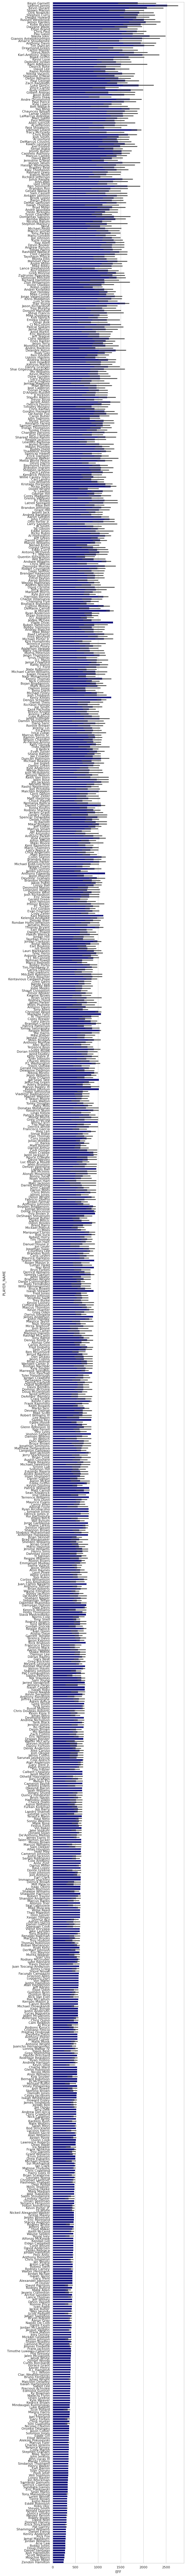

In [ ]:
plt.figure(figsize=(8,160))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 2}
plt.rc('font', **font)
sn.set_theme(style="whitegrid")
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="EFF", y="PLAYER_NAME", data=top_players,
            label="ELO", color="darkblue");
#ax.set(xlim=(1200, 2000));

In [ ]:
top_players_per_game = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(top_players, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
top_players_per_game = top_players_per_game.groupby(['GAME_ID', 'TEAM_ID', 'SEASON_x']).PLAYER_NAME.agg(lambda x: x.notnull().sum()).reset_index()
top_players_per_game.columns = ['GAME_ID', 'TEAM_ID', 'SEASON', 'TOP_PLAYERS']
#top_players_per_game.drop(columns='SEASON', inplace=True)

# Incorporating team fatigue
Players are humans and do get tired throughout the season. In order to measure this in the dataset the following variables are added:

**HG_7days**: Home games in the last 7 days

**AG_7days**: Away games in the last 7 days

**G_7days**: Total games in the last 7 days

**BACK2BACK**: Whether a team played a game the night before


In [ ]:
games_played = pd.melt(games_short, id_vars = ['GAME_ID', 'GAME_DATE_EST'], value_vars = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']).set_index('GAME_DATE_EST')
games_played['HOME_GAME'] = np.where(games_played.variable == "HOME_TEAM_ID", True, False)
games_played.drop(columns = 'variable', inplace = True)
games_played.rename(columns = {'value':'TEAM_ID'}, inplace = True)
games_played.sort_values(['TEAM_ID', 'GAME_DATE_EST'], inplace = True)

# Games in the last week # FAIRE DES TESTS 
games_played['HG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: x.rolling(window = "7d", closed='left', min_periods=0).sum())  # 14d
games_played['AG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: (~x).rolling(window = "7d", closed='left', min_periods=0).sum())
games_played['G_7days'] = games_played['HG_7days'] + games_played['AG_7days']

In [ ]:
# Back to back games
games_played.reset_index(inplace=True)
games_played['PAST_GAME'] = games_played.groupby(['TEAM_ID']).GAME_DATE_EST.transform(lambda x: x.shift(periods=1))
games_played['BACK2BACK'] = np.where((games_played.GAME_DATE_EST - games_played.PAST_GAME).dt.days == 1, 1, 0)
games_played.drop(columns = ['PAST_GAME', 'GAME_DATE_EST', 'HOME_GAME'], inplace=True)

In [ ]:
games_played.head()

,GAME_ID,TEAM_ID,HG_7days,AG_7days,G_7days,BACK2BACK
0,21600014,1610612737,0.0,0.0,0.0,0
1,21600026,1610612737,1.0,0.0,1.0,0
2,21600044,1610612737,1.0,1.0,2.0,0
3,21600059,1610612737,2.0,1.0,3.0,0
4,21600070,1610612737,2.0,1.0,3.0,0


In [ ]:
# Création dataset de modelisation
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

#Adding top players
input_data = input_data.merge(top_players_per_game, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(top_players_per_game, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding player efficiency
input_data = input_data.merge(pge, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(pge, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding team fatigue
input_data = input_data.merge(games_played, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(games_played, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

In [ ]:
# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

#input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'TEAM_ID_x', 'TEAM_ID_y', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
input_data = input_data.drop(columns = ['TEAM', 'TEAM_VISITOR'])
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO
input_data['TOP_PLAYER_DIFF'] = input_data.TOP_PLAYERS - input_data.TOP_PLAYERS_VISITOR
#input_data['MISSING_PLAYER_DIFF'] = input_data.MISSING_PLAYERS - input_data.MISSING_PLAYERS_VISITOR
input_data['EFF_DIFF'] = input_data.EFF - input_data.EFF_VISITOR
input_data['MONTH'] = input_data.GAME_DATE_EST.dt.month

input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM', 'CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)

In [ ]:
input_data.head(10)

,GAME_ID,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,TEAM_ID,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH
0,21600017,2016,1610612757,1610612746,0,1.610613e+09,2016-10-26,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,9,2016,9,1137.500000,1020.600000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1600.000000,1500.000000,100.000000,0,116.900000,10
1,21600016,2016,1610612758,1610612759,0,1.610613e+09,2016-10-26,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2016-10-26,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2016,10,2016,9,867.600000,1042.900000,0.0,1.0,1.0,1,0.0,0.0,0.0,0,1621.995971,1500.000000,121.995971,1,-175.300000,10
2,21600018,2016,1610612761,1610612739,0,1.610613e+09,2016-10-27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2016-10-27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2016,7,2016,7,1227.857143,1246.125000,1.0,0.0,1.0,0,0.0,0.0,0.0,0,1610.151834,1500.000000,110.151834,0,-18.267857,10
3,21600019,2016,1610612751,1610612754,1,1.610613e+09,2016-10-27,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2016-10-27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2016,5,2016,9,655.555556,885.500000,0.0,1.0,1.0,0,1.0,0.0,1.0,0,1595.309263,1506.488048,88.821215,-4,-229.944444,10
4,21600020,2016,1610612765,1610612753,1,1.610613e+09,2016-10-27,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2016-10-27,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2016,9,2016,9,915.727273,894.454545,0.0,1.0,1.0,0,1.0,0.0,1.0,0,1589.848166,1483.808839,106.039327,0,21.272727,10
5,21600023,2016,1610612742,1610612745,0,1.610613e+09,2016-10-27,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2016-10-27,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2016,7,2016,7,705.700000,760.545455,0.0,1.0,1.0,0,0.0,1.0,1.0,0,1593.511952,1494.845779,98.666173,0,-54.845455,10
6,21600022,2016,1610612748,1610612766,0,1.610613e+09,2016-10-27,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2016-10-27,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2016,7,2016,9,814.500000,932.400000,0.0,1.0,1.0,0,0.0,1.0,1.0,0,1616.191161,1515.321716,100.869445,-2,-117.900000,10
7,21600024,2016,1610612762,1610612747,1,1.610613e+09,2016-10-27,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2016-10-27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2016,9,2016,8,905.000000,768.909091,0.0,0.0,0.0,0,1.0,0.0,1.0,0,1600.000000,1505.154221,94.845779,1,136.090909,10
8,21600025,2016,1610612740,1610612744,0,1.610613e+09,2016-10-27,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2016-10-27,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2016,9,2016,8,709.333333,1481.700000,1.0,0.0,1.0,0,0.0,0.0,0.0,0,1590.207874,1500.000000,90.207874,1,-772.366667,10
9,21600021,2016,1610612760,1610612756,1,1.610613e+09,2016-10-27,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2016-10-27,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2016,7,2016,8,1221.750000,839.250000,0.0,1.0,1.0,0,1.0,0.0,1.0,0,1610.759671,1478.004029,132.755642,-1,382.500000,10


In [ ]:
# Splitting the data
train_data = input_data.loc[(input_data.SEASON < 2019) & (input_data.SEASON > 2016)]  ### CLE
valid_data = input_data.loc[input_data.SEASON == 2019]
test_data = input_data.loc[input_data.SEASON == 2020]
full_train_data = pd.concat([train_data, valid_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
valid_games = valid_X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

Afin de tirer pleinement parti de l'ensemble de données, nous allons tuner les paramètres en fonction de l'ensemble de validation et après avoir sélectionné les meilleurs, nous allons reutiliser le modèle sur la validation et l'ensemble d'apprentissage avant de faire les prédictions finales.
Pour générer les prédictions, nous allons utiliser CatBoost

**Prédiction simple**

1) Le résultat du jeu sera le même que le résultat de la rencontre précédente entre les mêmes équipes

2) L'équipe à domicile va gagner. Généralement, l'équipe à domicile a un avantage statistique en NBA (comme dans la plupart des sports)


In [ ]:
def calc_accuracy(model, test_X, test_y):
    return(np.round(accuracy_score(model.predict(test_X), test_y)*100,2))
    
def add_accuracy(model, model_name, test_X, test_y):
    test_acc = calc_accuracy(model, test_X, test_y)
    resultats_l.append([model_name, test_acc, len(test_X.columns)])
    print(model_name + ' test accuracy: ' + str(test_acc) + ' %')
    
resultats_l = []


In [ ]:
games_short.sort_values("GAME_DATE_EST", inplace=True)
naive = pd.merge_asof(games_short, games_short[['GAME_DATE_EST', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS']], on = 'GAME_DATE_EST', by = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], allow_exact_matches = False, suffixes=(['', '_p']))
naive = naive.dropna()

print('Resultat identique au dernier match: ' + str(np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2)) + ' %')
print("Victoire de l'équipe à domicile : " + str(np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2)) + ' %')

resultats_l.append(['Resultat identique au dernier match', np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2), 1])
resultats_l.append(["Victoire de l'équipe à domicile", np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2), 0])

Resultat identique au dernier match: 56.21 %
Victoire de l'équipe à domicile : 57.55 %


**Prédiction ELO**

In [ ]:
print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
resultats_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 60.48 %


**Catboost model**

In [ ]:
catb = CatBoostClassifier(verbose=False)
catb.fit(full_train_X, full_train_y)
add_accuracy(catb, 'Full model', test_X, test_y)

Full model test accuracy: 64.56 %


In [ ]:
# AVEC CROSS VAL
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('catb2_CV', CatBoostClassifier(verbose=False)))
model = Pipeline(estimators)
X = full_train_X
y = full_train_y

kfold = KFold(n_splits=5)
results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
results = np.round(np.mean(results),3)
print ('CV Scoring Result: ACC0=',results)

CV Scoring Result: ACC0= nan


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion



 **Autres modèles**

In [ ]:
# step 1 -> modification des datetimes values => int

In [ ]:
full_train_X['STANDINGSDATE'] = full_train_X['STANDINGSDATE'].dt.dayofyear
full_train_X['STANDINGSDATE_VISITOR'] = full_train_X['STANDINGSDATE_VISITOR'].dt.dayofyear

In [ ]:
# Construct the pipeline with a standard scaler and a small neural network
estimators1 = []
estimators1.append(('standardize', StandardScaler()))
estimators1.append(('nn', MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)))
model1 = Pipeline(estimators1)
X = full_train_X.values
y = full_train_y.values
# We'll use 5-fold cross validation. That is, a random 80% of the data will be used
# to train the model, and the prediction score will be computed on the remaining 20%.
# This process is repeated five times such that the training sets in each "fold"
# are mutually orthogonal.
kfold = KFold(n_splits=5)
results1 = cross_val_score(model1, X, y, cv=kfold, scoring='accuracy')
results1 = np.round(np.mean(results1),3)
print ('CV Scoring Result: ACC1=',results)

CV Scoring Result: ACC1= nan


In [ ]:
estimators2 = []
estimators2.append(('standardize', StandardScaler()))
estimators2.append(('rf', RandomForestClassifier(n_estimators=500)))
model2 = Pipeline(estimators2)
X = full_train_X.values
y = full_train_y.values
kfold = KFold(n_splits=5)
results2 = cross_val_score(model2, X, y, cv=kfold, scoring='accuracy')
results2 = np.round(np.mean(results2),3)
print ('CV Scoring Result: ACC2=',results2)

CV Scoring Result: ACC2= 0.659


In [ ]:
#add_accuracy(results2, 'Full model_RF', test_X, test_y)

# 'numpy.float64' object has no attribute 'predict'

In [ ]:
estimators3 = []
estimators3.append(('standardize', StandardScaler()))
estimators3.append(('ad', AdaBoostClassifier(n_estimators=100, learning_rate=.5)))
model3 = Pipeline(estimators3)
X = full_train_X.values
y = full_train_y.values
kfold = KFold(n_splits=5)
results3 = cross_val_score(model3, X, y, cv=kfold, scoring='accuracy')
results3 = np.round(np.mean(results3),3)
print ('CV Scoring Result: ACC3=',results3)

CV Scoring Result: ACC3= 0.651


In [ ]:
#add_accuracy(results3, 'Full model_ADAB', test_X, test_y)

### **Feature selection**

In [ ]:
# simple filtering CATBOOST

pipe = Pipeline([
    ('reduce_dim', SelectKBest(f_classif)),
    ('classify', CatBoostClassifier(verbose=False))
])

param_grid = [
      { 'reduce_dim__k': [8, 10, 12],
        'classify__depth':[3, 5, 7]}]

sf_grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid)
_ = sf_grid.fit(X, y)

divide by zero encountered in true_divide


In [ ]:
features_selected = sf_grid.best_params_['reduce_dim__k']
print("The GridSearch selected " + str(features_selected) + ' features with a tree depth of ' + str(sf_grid.best_params_['classify__depth']))


The GridSearch selected 10 features with a tree depth of 3


In [ ]:
feature_score_df = pd.DataFrame({'Feature':full_train_X.columns, 'Score':sf_grid.best_estimator_['reduce_dim'].scores_}).sort_values(by='Score', ascending=False).head(features_selected)
feature_score_df

,Feature,Score
35,ELO_DIFF,337.856898
33,HOME_ELO,206.312745
37,EFF_DIFF,156.801123
34,VISITOR_ELO,127.251275
23,EFF,76.880140
36,TOP_PLAYER_DIFF,75.187148
24,EFF_VISITOR,67.508331
20,TOP_PLAYERS,56.359513
8,HOME_L,54.934239
6,L,47.366847


In [ ]:
# simple filtering RANDOMFOREST

pipe2 = Pipeline([
    ('reduce_dim', SelectKBest(f_classif)),
    ('classify', RandomForestClassifier())
])

param_grid2 = [{'reduce_dim__k': [8, 10, 12],'classify__min_samples_leaf': [2, 3, 5], 'classify__n_estimators': [100, 500, 1000] }]

sf_grid = GridSearchCV(pipe2, n_jobs=-1, param_grid=param_grid2)
_ = sf_grid.fit(X, y)

divide by zero encountered in true_divide


In [ ]:
sf_grid.best_params_

{'classify__min_samples_leaf': 5,
 'classify__n_estimators': 100,
 'reduce_dim__k': 12}

In [ ]:
features_selected_2 = sf_grid.best_params_['reduce_dim__k']

In [ ]:
feature_score_df = pd.DataFrame({'Feature':full_train_X.columns, 'Score':sf_grid.best_estimator_['reduce_dim'].scores_}).sort_values(by='Score', ascending=False).head(features_selected_2)
feature_score_df

,Feature,Score
35,ELO_DIFF,337.856898
33,HOME_ELO,206.312745
37,EFF_DIFF,156.801123
34,VISITOR_ELO,127.251275
23,EFF,76.880140
36,TOP_PLAYER_DIFF,75.187148
24,EFF_VISITOR,67.508331
20,TOP_PLAYERS,56.359513
8,HOME_L,54.934239
6,L,47.366847


In [ ]:
#rf = RandomForestClassifier(verbose=False)
#rf.get_params().keys()


In [ ]:
# simple MLPClassifier
#pipe3 = Pipeline([
#    ('reduce_dim', SelectKBest(f_classif)),
#    ('classify', MLPClassifier())
#])
# param_grid3 = [{'reduce_dim__k': [8, 10, 12],'classify__hidden_layer_sizes': [5, 10, 15], 'classify__activation': [logistic, tanh, relu] }]
# sf_grid = GridSearchCV(pipe3, n_jobs=-1, param_grid=param_grid3)
# _ = sf_grid.fit(X, y)

## Importance de la permutation
### L'idée derrière l'importance de la permutation pour une seule caractéristique est très simple :
### 1) Calculer l'erreur globale du modèle
### 2) Mélangez les valeurs de la fonctionnalité de manière aléatoire afin de briser toute association entre la fonctionnalité et le résultat
### 3) Calculer de combien l'erreur du modèle change avec le nouveau brassage

In [ ]:
# https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

In [ ]:
X.head(1) # recréer X avant (anti chronologique)

,HOME_TEAM_ID,VISITOR_TEAM_ID,TEAM_ID,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH
1215,1610612759,1610612750,1.610613e+09,2017-04-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-04-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,8,2017,9,575.727273,1198.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1701.351559,1472.136099,229.21546,-1,-622.272727,10


In [ ]:
# triche pour débugger X_bis à la place de X
X_bis=X.drop(['STANDINGSDATE','STANDINGSDATE_VISITOR'], axis=1)

## permutation importance

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    best_valid_acc = 0
    for features in [8, 10, 12]:
        for depth in [3,5,7]:
            pi_catb = CatBoostClassifier( mns[np.argpartition(perm.feature_importances_, -features)[-features:]].tolist()

            valid_X_pi = valid_X[selected_columns]
            pi_catb.fit(X_bis[selected_columns], y)

            valid_acc = np.round(accuracy_score(pi_catb.predict(valid_X_pi), valid_y),3)
            if valid_acc > best_valid_acc:
                pi_features = selected_columns
                pi_depth = depth
                best_valid_acc = valid_acc    

full_train_X_pi = full_train_X[pi_features]
test_X_pi = test_X[pi_features]
pi_model = CatBoostClassifier(verbose=False, depth=pi_depth)
pi_model.fit(full_train_X_pi, full_train_y)

SyntaxError: ignored

In [ ]:
pd.DataFrame(pi_features[::-1], columns = ['Features'])

In [ ]:
# catboostmodel
add_accuracy(pi_model, 'Permutation importance', test_X_pi, test_y)

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    best_valid_acc = 0
    for features in [8, 10, 12]:
        #for depth in [3,5,7]:
            pi_rf = RandomForestClassifier(verbose=False)
            perm = PermutationImportance(estimator=pi_rf, cv=3).fit(X_bis.reset_index(drop=True), y.reset_index(drop=True))
            selected_columns = X_bis.columns[np.argpartition(perm.feature_importances_, -features)[-features:]].tolist()

            valid_X_pi = valid_X[selected_columns]
            pi_rf.fit(X_bis[selected_columns], y)

            valid_acc = np.round(accuracy_score(pi_rf.predict(valid_X_pi), valid_y),3)
            if valid_acc > best_valid_acc:
                pi_features = selected_columns
                #pi_depth = depth
                best_valid_acc = valid_acc    

full_train_X_pi = full_train_X[pi_features]
test_X_pi = test_X[pi_features]
pi_model = RandomForestClassifier(verbose=False)
pi_model.fit(full_train_X_pi, full_train_y)

In [ ]:
pd.DataFrame(pi_features[::-1], columns = ['Features'])

In [ ]:
# randomforest
add_accuracy(pi_model, 'Permutation importance', test_X_pi, test_y)

## Feature importance avec le modèle baseline "CATBOOST"
Par feature importance : dans le contexte d'un arbre de boost, on entend ce qui suit : Quelle est l'efficacité (en termes de réduction de la perte ou de l'impureté des nœuds) est-ce que les divisions basées sur chaque attribut particulier ? Il y a plusieurs facteurs à prendre en compte ici :

L'efficacité est pondérée par le nombre d'observations à chaque division, de sorte que les divisions qui se produisent plus haut dans l'arbre ont plus d'impact (plus nous descendons dans l'arbre de décision, moins il y a d'observations à diviser)
Le nombre d'arbres utilisant un attribut pour un fractionnement est important ici. Plus d'arbres utilisant l'attribut pour un fractionnement --> Score plus élevé pour l'attribut

In [ ]:
train_pool = Pool(X, y)
best_valid_acc = 0

for features in [8, 10, 12]:
    for depth in [3, 5, 7]:
        fi_catb = CatBoostClassifier(verbose=False, depth = depth)
        summary = fi_catb.select_features(X=train_pool, 
                                features_for_select=X.columns.to_list(),
                                num_features_to_select = features,
                                steps = 3,
                                logging_level='Silent',
                                train_final_model=True,
                                algorithm = 'RecursiveByLossFunctionChange',
                                plot=False)
        valid_acc = np.round(accuracy_score(fi_catb.predict(valid_X), valid_y),3)
        if valid_acc > best_valid_acc:
            fi_model = fi_catb
            fi_depth = depth
            fi_features = summary['selected_features_names']
            best_valid_acc = valid_acc

full_train_X_fi = full_train_X[fi_features]
test_X_fi = test_X[fi_features]
fi_model = CatBoostClassifier(verbose=False, depth=fi_depth)
fi_model.fit(full_train_X_fi, full_train_y)

In [ ]:
pd.DataFrame(fi_features[::-1], columns = ['Features'])

In [ ]:
pd.DataFrame(fi_features[::], columns = ['Features']) # ordre inverse dimportance

## SHAP importance

Le dernier algorithme de sélection des caractéristiques est la sélection par les valeurs SHAP. L'idée derrière l'algorithme est assez similaire à l'algorithme d'importance des caractéristiques ci-dessus, la seule différence étant qu'au lieu de sélectionner les caractéristiques qui entraînent la plus forte diminution des pertes, nous sélectionnons les caractéristiques qui ont en moyenne les valeurs SHAP les plus élevées.

In [ ]:
# CATBOOST
train_pool = Pool(X, y)

valid_acc = 0
for features in [8, 10, 12]:
    for depth in [3, 5, 7]:
        si_catb = CatBoostClassifier(verbose=False, depth = depth)
        summary = si_catb.select_features(X=train_pool, 
                                features_for_select=X.columns.to_list(),
                                num_features_to_select = features,
                                steps = 3,
                                logging_level='Silent',
                                algorithm = 'RecursiveByShapValues', ####
                                train_final_model=True,
                                plot=False)
        valid_acc = np.round(accuracy_score(si_catb.predict(valid_X), valid_y),3)
        if valid_acc > best_valid_acc:
            si_depth = depth
            si_features = summary['selected_features_names']
            best_valid_acc = valid_acc

In [ ]:
pd.DataFrame(si_features[::-1], columns=['Features'])

In [ ]:
# non applicable à RANDOMFOREST
train_pool = Pool(X, y)

In [ ]:
dir(train_pool)

In [ ]:
# https://www.codesdope.com/blog/article/multiprocessing-using-pool-in-python/

In [ ]:
pd.DataFrame(resultats_l, columns = ['Model name', 'Test accuracy', 'Features']).sort_values(by='Test accuracy', ascending=False)

In [ ]:
# Sans oublier le meilleur modèle qui est un randomforest

In [ ]:
# Full model et Permutation importance ont des résultats très proches (Catboost)

Le modèle complet randomforest suivi de catboost avec toutes les fonctionnalités disponibles permet d'obtenir la meilleure précision de test. Néanmoins, les méthodes de sélection de caractéristiques (en particulier celles de Permutation et d'importance de la forme) atteignent une précision comparable avec un nombre de caractéristiques significativement plus petit.

Pour le basket-ball, le coefficient de compétence est assez élevé car il s'agit d'un jeu à score élevé qui donne de nombreuses opportunités aux équipes hautement qualifiées de briller. Ils ont cependant effectué une analyse sur la saison régulière de la NBA pour voir à quelle fréquence un outsider gagne le match. Le chiffre qu'ils ont obtenu (moyenne sur les saisons 2012-2016) est d'environ 36% du temps. Cela nous donne un chiffre approximatif de l'imprévisibilité de la saison régulière.
Veuillez noter que malgré l'analyse de cet article, il y a toujours des améliorations à apporter à tout algorithme de prédiction !